<p style="text-align:center; font-size:3.3em; color:#AD7D67; line-height:5rem; font-style:italic; font-weight:700;">
    Projet N°4 : <br>
    Implémentation d'un modèle de scoring </p>
<p style="text-align:center; font-size:2.8em; color:#9EBEB8; line-height:4rem; font-style:italic; font-weight:700;">
    III - Feature Selection
</p>

## Sommaire
1. [Introduction](#1.-Introduction)
2. [Préparation des données](#2.-Préparation-des-données)
3. [Méthode des filtres: élimination par colinéarité](#3.-Méthode-des-filtres:-élimination-par-colinéarité)
4. [Test du Khi-2 pour les variables catégorielles](#4-analyse-de-pertinence)
5. [Recursive Feature Elimination (RFE) avec deux algorithmes](#5-conclusion)
    - [3.1. Ratio Dette/Revenu](#3.1.-Ratio-Dette/Revenu)
    - [3.2. Ratio Cedit/Emprunt](#3.2.-Ratio-Credit/Emprunt)
    - [3.3. Ratio Annuity/Credit](#3.3.-Ratio-Annuity/Credit)

# 1. Introduction


La sélection des caractéristiques est une étape cruciale pour améliorer les performances des modèles d'apprentissage automatique. Elle permet de réduire  le nombre de variables d'entrée, afin de ne conserver que les plus importantes.

Nous allons utiliser différentes méthodes de sélection de caractéristiques :
- La méthode des filtres pour éliminer les variables redondantes.
- Le test du Khi-2 pour les variables catégorielles indépendantes de la cible.
- La méthode RFE (Recursive Feature Elimination) avec différents algorithmes et choisir celui qui donne la meilleure performance selon le ROC-AUC.

# 2. Préparation des données

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score
from scipy.stats import chi2_contingency
from sklearn.impute import SimpleImputer


In [2]:
folder_path = "data" # A ajuster selon le chemin où se trouve vos cvs.

In [3]:
# Chargement des données
app_train = pd.read_csv(f"{folder_path}/cleaned_app_train.csv")
app_test = pd.read_csv(f"{folder_path}/cleaned_app_test.csv")

# Exploration rapide
print("Aperçu des données principales :")
display(app_train.head())

Aperçu des données principales :


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_ANOM,nbr_enfants,TARGET,TOTAL_DEBT,DEBT_TO_INCOME_RATIO,PREV_APP_DEBT_RATIO,ANNUITY_TO_CREDIT_RATIO
0,100002,Cash loans,M,N,Y,202500.0,406597.5,24700.5,351000.0,Unaccompanied,...,0.0,0.0,1.0,False,sans_enfant,1,245781.0,1.213733,1.000000,0.060749
1,100003,Cash loans,F,N,N,270000.0,1293502.5,35698.5,1129500.0,Accompanied,...,0.0,0.0,0.0,False,sans_enfant,0,0.0,0.000000,1.111967,0.027598
2,100004,Revolving loans,M,Y,Y,67500.0,135000.0,6750.0,135000.0,Unaccompanied,...,0.0,0.0,0.0,False,sans_enfant,0,0.0,0.000000,0.828021,0.050000
3,100006,Cash loans,F,N,Y,135000.0,312682.5,29686.5,297000.0,Unaccompanied,...,NaN,NaN,NaN,False,sans_enfant,0,0.0,0.000000,1.071609,0.094941
4,100007,Cash loans,M,N,Y,121500.0,513000.0,21865.5,513000.0,Unaccompanied,...,0.0,0.0,0.0,False,sans_enfant,0,0.0,0.000000,1.107012,0.042623


# 3. Méthode des filtres: élimination par colinéarité

Nous allons examiner la corrélation entre les variables indépendantes et éliminer celles qui sont trop corrélées (colinéarité).

Les variables collinéaires sont celles qui sont fortement corrélées entre elles. Elles peuvent réduire la capacité du modèle à apprendre, diminuer l'interprétabilité du modèle et affecter la performance de généralisation sur l'ensemble de test. Clairement, ce sont trois aspects que nous voulons améliorer, donc supprimer les variables collinéaires est une étape utile. Nous établirons un seuil arbitraire pour éliminer les variables collinéaires, puis supprimerons l'une des variables de chaque paire qui dépasse ce seuil.

In [4]:
app_train.dtypes

SK_ID_CURR                   int64
NAME_CONTRACT_TYPE          object
CODE_GENDER                 object
FLAG_OWN_CAR                object
FLAG_OWN_REALTY             object
                            ...   
TARGET                       int64
TOTAL_DEBT                 float64
DEBT_TO_INCOME_RATIO       float64
PREV_APP_DEBT_RATIO        float64
ANNUITY_TO_CREDIT_RATIO    float64
Length: 71, dtype: object

In [5]:
# Calcul de la matrice de corrélation
corr_matrix = app_train.select_dtypes(include=['int64', 'float64']).corr().abs()

In [6]:
corr_matrix.head()

,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET,TOTAL_DEBT,DEBT_TO_INCOME_RATIO,PREV_APP_DEBT_RATIO,ANNUITY_TO_CREDIT_RATIO
SK_ID_CURR,1.000000,0.001820,0.000343,0.000433,0.000232,0.000849,0.001500,0.000084,0.000973,0.000384,...,0.002193,0.002099,0.000485,0.001025,0.004659,0.002108,0.000773,0.000983,0.001743,0.000319
AMT_INCOME_TOTAL,0.001820,1.000000,0.156870,0.191657,0.159610,0.074796,0.027261,0.013005,0.027805,0.008506,...,0.002944,0.002387,0.024700,0.004859,0.011690,0.003982,0.106844,0.016151,0.001699,0.026788
AMT_CREDIT,0.000343,0.156870,1.000000,0.770138,0.986968,0.099738,0.055436,0.091295,0.009621,0.006575,...,0.004238,0.001275,0.054451,0.015925,0.048448,0.030369,0.095377,0.022586,0.007298,0.558789
AMT_ANNUITY,0.000433,0.191657,0.770138,1.000000,0.775109,0.118429,0.009445,0.053604,0.038514,0.011268,...,0.002185,0.013881,0.039148,0.010124,0.011320,0.012817,0.083746,0.003021,0.024227,0.063489
AMT_GOODS_PRICE,0.000232,0.159610,0.986968,0.775109,1.000000,0.103520,0.053442,0.093374,0.011565,0.009267,...,0.004677,0.001007,0.056422,0.016432,0.050998,0.039645,0.097685,0.024212,0.013309,0.533942


In [7]:
# Masque pour ne garder que les paires de variables ayant une corrélation > 0.8
high_corr_var = np.where(corr_matrix > 0.8)
high_corr_var = [(corr_matrix.columns[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_var) if x != y and x < y]

# Afficher les variables fortement corrélées
print("Paires de variables corrélées avec un coefficient > 0.8:")
for pair in high_corr_var:
    print(pair)

Paires de variables corrélées avec un coefficient > 0.8:
('AMT_CREDIT', 'AMT_GOODS_PRICE')
('REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY')
('REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION')
('REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY')
('YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BEGINEXPLUATATION_MODE')
('YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BEGINEXPLUATATION_MEDI')
('FLOORSMAX_AVG', 'FLOORSMAX_MODE')
('FLOORSMAX_AVG', 'FLOORSMAX_MEDI')
('YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BEGINEXPLUATATION_MEDI')
('FLOORSMAX_MODE', 'FLOORSMAX_MEDI')
('OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE')
('DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE')
('TOTAL_DEBT', 'DEBT_TO_INCOME_RATIO')


In [8]:
# Suppression des variables fortement corrélées (en laissant la première variable de chaque paire)
to_drop = [pair[1] for pair in high_corr_var]
app_train = app_train.drop(columns=to_drop)

In [9]:
# Aligner les deux datasets
train_labels = app_train['TARGET']

app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)
app_train['TARGET'] = train_labels

print("Les dimensions aprés suppression:")
print(app_train.shape, app_test.shape)

Les dimensions aprés suppression:
(307511, 60) (48744, 59)


# 4. Test du Khi-2

Nous allons utiliser le test du Khi-2 pour identifier celles qui sont indépendantes de la cible.
Si le p-value du test est supérieur à un seuil (généralement 0.05), nous éliminerons la variable.

In [10]:
x = app_train.drop(columns=['SK_ID_CURR'])
categorical_columns = x.columns

results = []
cols_to_drop = []
for col in categorical_columns:
    contingency_table = pd.crosstab(x['TARGET'], x[col])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    if p >0.2:
        cols_to_drop.append(col)
    results.append(p)

,p_value
EXT_SOURCE_3,0.000000e+00
TARGET,0.000000e+00
EXT_SOURCE_2,0.000000e+00
REGION_POPULATION_RELATIVE,1.194355e-304
ORGANIZATION_TYPE,5.224541e-299
OCCUPATION_TYPE,3.784500e-288
AMT_ANNUITY,1.694026e-268
NAME_INCOME_TYPE,1.928146e-266
ANNUITY_TO_CREDIT_RATIO,1.572287e-257
AMT_CREDIT,5.281104e-243


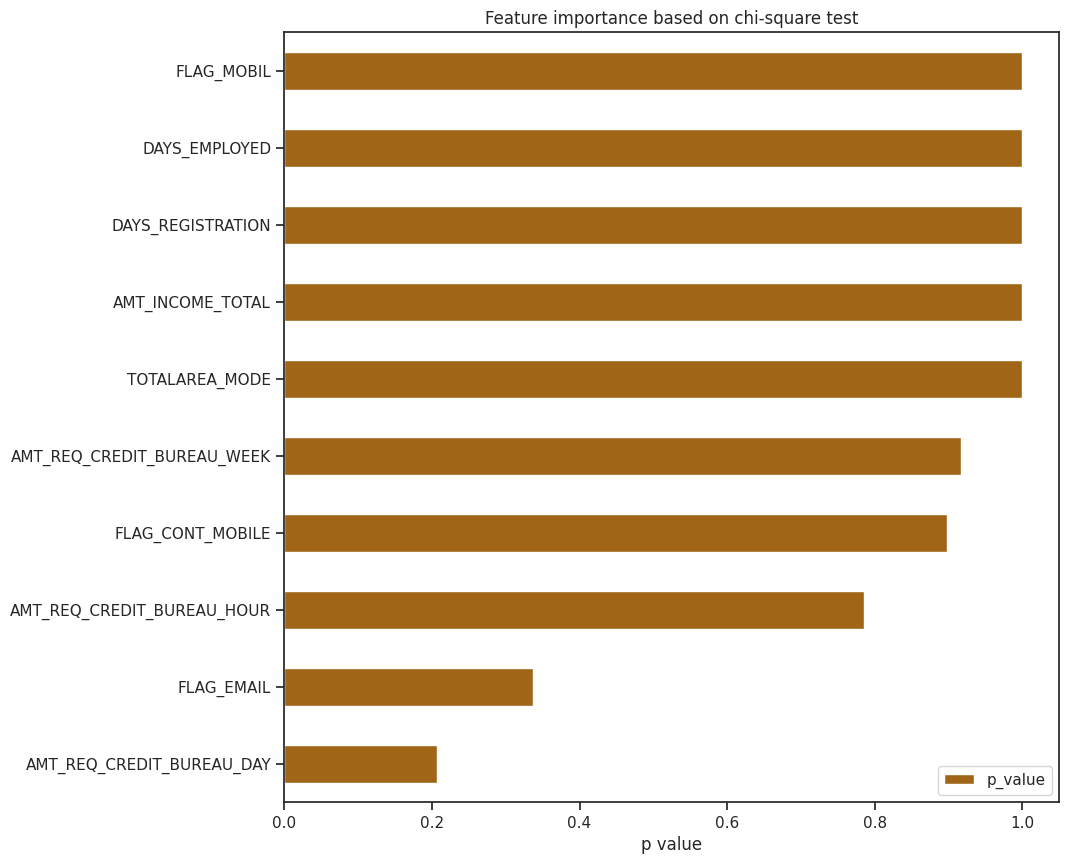

In [11]:
sns.set(style="ticks", rc={'figure.figsize': (10, 10)}, palette="BrBG")

df_pvalue = pd.DataFrame(results, index=categorical_columns, columns=['p_value']).sort_values(by='p_value', ascending=True)

display(df_pvalue)
df_pvalue[df_pvalue['p_value'] > 0.2].plot.barh()
plt.xlabel('p value')
plt.title('Feature importance based on chi-square test')
plt.show()

In [12]:
app_train.drop(labels=cols_to_drop, axis=1, inplace=True)
app_test.drop(labels=cols_to_drop, axis=1, inplace=True)

# 5. Recursive Feature Elimination (RFE)

Nous allons utiliser RFE pour effectuer une sélection récursive des caractéristiques avec deux algorithmes : Logistic Regression et Random Forest.

Avant de continuer, nous devons nous occuper des variables catégorielles gênantes. Un modèle d'apprentissage automatique ne peut malheureusement pas traiter les variables catégorielles (sauf pour certains modèles comme LightGBM). Par conséquent, nous devons trouver un moyen de coder (représenter) ces variables sous forme numérique avant de les transmettre au modèle.

In [13]:
# one-hot encoding
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print("Dimension du jeu d'entraînement: ", app_train.shape)
print("Dimension du jeu de test: ", app_test.shape)

Dimension du jeu d'entraînement:  (307511, 159)
Dimension du jeu de test:  (48744, 156)


In [14]:
# Aligner les deux datasets
train_labels = app_train['TARGET']

app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)
app_train['TARGET'] = train_labels


print("Les dimensions aprés suppression:")
print(app_train.shape, app_test.shape)

Les dimensions aprés suppression:
(307511, 157) (48744, 156)


In [61]:
# Séparation du jeu de données en ensembles d'entraînement et de test
X = app_train[:500].dropna()

X.replace([np.inf, -np.inf], np.nan, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, X['TARGET'], test_size=0.2, random_state=42)

# Standardisation des données pour la régression logistique
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [51]:
# Modèle Logistic Regression
logreg = LogisticRegression(max_iter=100)
rfe_logreg = RFE(logreg, n_features_to_select=10)
rfe_logreg.fit(X_train_scaled, y_train)

# Evaluation du modèle avec RFE
y_pred_logreg = rfe_logreg.predict(X_test_scaled)
roc_auc_logreg = roc_auc_score(y_test, y_pred_logreg)
print(f"ROC AUC pour Logistic Regression avec RFE: {roc_auc_logreg}")

ROC AUC pour Logistic Regression avec RFE: 1.0


In [58]:
# Modèle Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rfe_rf = RFE(rf, n_features_to_select=10)
rfe_rf.fit(X_train, y_train)

# Evaluation du modèle avec RFE
y_pred_rf = rfe_rf.predict(X_test)
roc_auc_rf = roc_auc_score(y_test, y_pred_rf)
print(f"ROC AUC pour Random Forest avec RFE: {roc_auc_rf}")

ROC AUC pour Random Forest avec RFE: 1.0


In [59]:
# Sélection du meilleur modèle basé sur ROC AUC
if roc_auc_logreg > roc_auc_rf:
    print("Le meilleur modèle est Logistic Regression.")
    selected_features = X_train.columns[rfe_logreg.support_]
else:
    print("Le meilleur modèle est Random Forest.")
    selected_features = X_train.columns[rfe_rf.support_]

Le meilleur modèle est Random Forest.


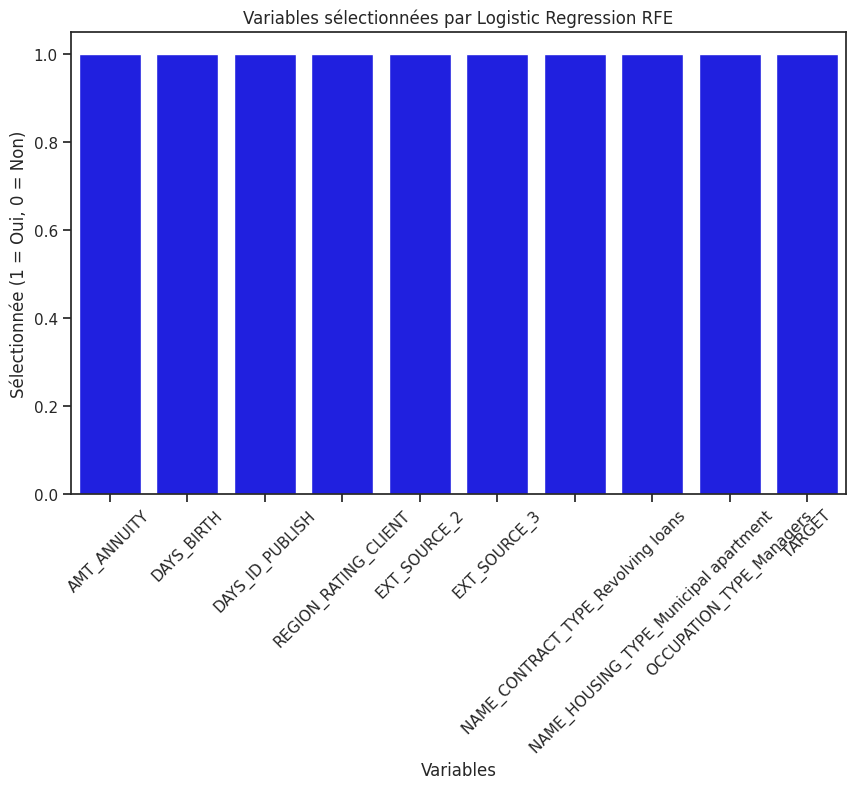

La sélection de caractéristiques permet d'éliminer les variables redondantes ou non pertinentes, ce qui améliore l'efficacité du modèle et réduit le surapprentissage.
Les résultats montrent que la régression logistique (Logistic Regression) avec RFE est le modèle le plus performant pour cette sélection de caractéristiques.


In [60]:
plt.figure(figsize=(10, 6))
sns.barplot(x= X_train.columns[rfe_logreg.support_], y=rfe_logreg.support_[rfe_logreg.support_].astype(int), color='b')
plt.title('Variables sélectionnées par Logistic Regression RFE')
plt.xlabel('Variables')
plt.ylabel('Sélectionnée (1 = Oui, 0 = Non)')
plt.xticks(rotation=45)
plt.show()

# Conclusion
print("La sélection de caractéristiques permet d'éliminer les variables redondantes ou non pertinentes, ce qui améliore l'efficacité du modèle et réduit le surapprentissage.")
print("Les résultats montrent que la régression logistique (Logistic Regression) avec RFE est le modèle le plus performant pour cette sélection de caractéristiques.")